<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day5/Day_5_1_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 5.1 Word Embedding
### 실습 목표
- 단어를 밀집 벡터(dense vector)로 표현하는 방법을 알아봅시다

#### pytorch에서 embedding vector를 사용하는 방법에는 크게 두 가지가 존재
1. embedding layer를 만들어 훈련데이터로부터 처음부터 임베딩 벡터를 학습하는 방법 -> `nn.Embedding()`
2. pre-trained word embedding을 가져와 사용하는 방법 -> `word2vec`

In [4]:
# 코랩에서 한글을 그래프에 나타내려면 한글폰트 설치 필요
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import matplotlib.font_manager
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)



## 1.1 nn.Embedding()을 사용하지 않고 구현해보기
- 어떤 단어 -> 단어에 부요된 고유한 정수값 -> 임베딩 층 통과 -> 밀집 벡터

![image.png](https://user-images.githubusercontent.com/46921003/120502804-b2de7e00-c3fd-11eb-9716-48d19e9ebf76.png)


In [5]:
import torch
import torch.nn as nn

In [6]:
train_data = 'you need to know how to code'
word_set = set(train_data.split()) # 중복을 제거한 단어들의 집합인 단어 집합 생성.
print(word_set)
print()
vocab = {word: i+2 for i, word in enumerate(word_set)}  # 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab['<unk>'] = 0
vocab['<pad>'] = 1
print(vocab)

{'know', 'how', 'to', 'code', 'need', 'you'}

{'know': 2, 'how': 3, 'to': 4, 'code': 5, 'need': 6, 'you': 7, '<unk>': 0, '<pad>': 1}


In [7]:
# 단어 집합의 크기만큼의 행을 가지는 테이블 생성.
embedding_table = torch.FloatTensor([
                               [ 0.0,  0.0,  0.0],
                               [ 0.0,  0.0,  0.0],
                               [ 0.2,  0.9,  0.3],
                               [ 0.1,  0.5,  0.7],
                               [ 0.2,  0.1,  0.8],
                               [ 0.4,  0.1,  0.1],
                               [ 0.1,  0.8,  0.9],
                               [ 0.6,  0.1,  0.1]])

In [8]:
embedding_table.shape

torch.Size([8, 3])

In [9]:
# 임의의 샘플 문장
sample = 'you need to run'.split()
idxes=[]
# 각 단어를 정수로 변환
for word in sample:
  try:
    idxes.append(vocab[word])
  except KeyError: # 단어 집합에 없는 단어일 경우 <unk>로 대체된다.
    idxes.append(vocab['<unk>'])
idxes = torch.LongTensor(idxes)
idxes

tensor([7, 6, 4, 0])

In [10]:
# 룩업 테이블
lookup_result = embedding_table[idxes, :] # 각 정수를 인덱스로 임베딩 테이블에서 값을 가져온다.
print(lookup_result)

tensor([[0.6000, 0.1000, 0.1000],
        [0.1000, 0.8000, 0.9000],
        [0.2000, 0.1000, 0.8000],
        [0.0000, 0.0000, 0.0000]])


## 1.2 nn.Embedding()을 사용하여 구현

- 훈련 데이터 학습을 위한 임베딩층을 만들어 주는 역할
- 입력 시퀀스는 정수로 인코딩 되어야 함

- one hot encoding 형식으로 나타내면 잘 나타낼 수 있을텐데 왜 사용하는지?
> - 단어의 개수가 늘어나게 되면 벡터의 크기가 계속 증가..
> - 단어간 유사성을 파악하기 어려움
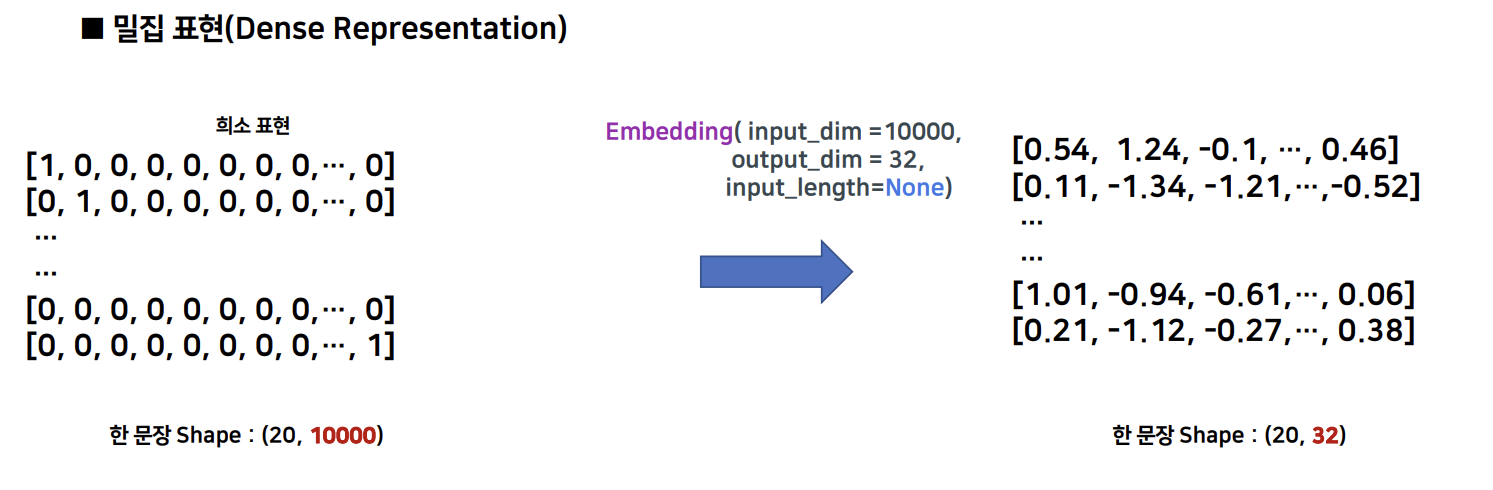

In [11]:
train_data = 'you need to know how to code'
word_set = set(train_data.split()) # 중복을 제거한 단어들의 집합인 단어 집합 생성.
vocab = {tkn: i+2 for i, tkn in enumerate(word_set)}  # 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab['<unk>'] = 0
vocab['<pad>'] = 1

### nn.Embedding(num_embeddings, embedding_dim)
- num_embeddings : 임베딩을 할 단어들의 개수(단어 집합의 크기)
- embedding_dim : 임베딩 할 벡터의 차원(사용자가 정하는 값)

In [12]:
embedding_layer = nn.Embedding(num_embeddings = len(vocab), embedding_dim = 3)

In [13]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 1.2396, -0.2124,  1.1038],
        [ 0.6066, -0.2193, -0.6854],
        [-1.2540,  0.1030,  0.5141],
        [-1.0315, -0.7953,  1.3679],
        [-0.6203, -0.9101, -0.5145],
        [ 0.0459,  1.1593,  1.0685],
        [ 0.8173, -0.1165, -1.9039],
        [ 1.1696,  1.0636,  0.3648]], requires_grad=True)


## 2. Word2Vec

- Distributed Representation
  - **비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다**
  - **단어의 의미를 여러 차원에다가 분산하여 표현**

- 훈련 데이터가 적다면 파이토치의 nn.Embedding()으로 해당 문제에 충분히 특화된 임베딩 벡터를 만들어내는 것이 쉽지 않음
- 이 경우, 해당 문제에 특화된 것은 아니지만 보다 일반적이고 보다 많은 훈련 데이터로 이미 Word2Vec이나 GloVe 등으로 학습되어져 있는 임베딩 벡터들을 사용 가능

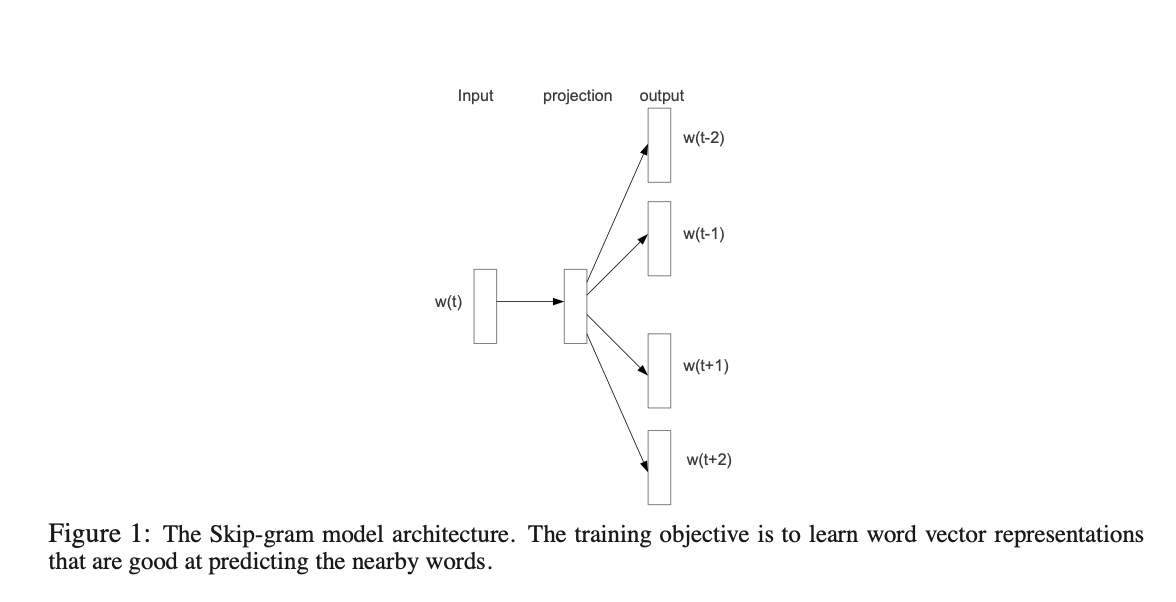


### pretrained word embedding

In [14]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1r8GSa4T9ezqUfwlPMT9WfOMRyTPS-EzB',
                                    dest_path='./wiki.w2v.wv.syn0.npy')
gdd.download_file_from_google_drive(file_id='1u81pn_XjCsBCd0s0PCzm4LpQnTRetD4n',
                                    dest_path='./wiki.w2v.syn1neg.npy')
gdd.download_file_from_google_drive(file_id='1QhRRYAnixo6d6u1KMZ2M_2T1_ynJLyzP',
                                    dest_path='./wiki.w2v')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
import gensim

In [16]:
drive_path = '/content/'

In [17]:
model = gensim.models.Word2Vec.load(os.path.join(drive_path, 'wiki.w2v'))

In [18]:
# word2vec의 vocab size확인
vocab = list(model.wv.index_to_key)
len(vocab)

190364

In [19]:
# 한국, 미국
for t in model.wv.most_similar(positive=['한국']):
    print('%s\t%f' % (t[0], t[1]))

우리나라	0.732175
해외	0.641399
일구팔영년_사월_일칠일	0.634419
전문지	0.633567
박지일	0.629534
중국	0.626936
일구팔구년_일이월_일사일	0.622048
국내	0.619023
일삼영주년	0.611076
이영일일년_삼월_이사일	0.608190


In [20]:
# 일본+도쿄
for t in model.wv.most_similar(positive=['한국', '서울']):
    print('%s\t%f' % (t[0], t[1]))

광주	0.720850
부산	0.709166
인천	0.708911
대구	0.707786
일구팔영년_사월_일칠일	0.692578
주한_일본_대사관	0.691746
광주광역시	0.680948
일영영주년_기념관	0.680791
일구팔팔년_팔월_이영일	0.676055
경기_지역	0.674747


In [21]:
for t in model.wv.most_similar('컴퓨터'):
    print(t[0])

하드웨어
컴퓨팅
소프트웨어
에뮬레이트하
비디오_플레이어
데스크톱_컴퓨터
핸드헬드
핸드셋
임베디드
클라우드_컴퓨팅


In [22]:
model.wv.similarity('고양이', '개')

0.45331413

In [23]:
for t in model.wv.most_similar('고양이'):
    print(t[0])

토끼
야생고양이
페럿
개구리
샴고양이
늑대
가미네코
생쥐
애완
애완견


In [24]:
model.wv.similarity('호랑이', '표범')

0.78993887

In [25]:
model.wv.similarity('호랑이', '개')

0.348036

In [26]:
for t in model.wv.most_similar('오렌지',topn=15):
    print(t[0])

바나나
파인애플
일이컵
코코야자
원두커피
인디고
바닐라
화이트_초콜릿
다크_초콜릿
퀸즈랜드
메이플_시럽
코코넛
블루베리
핑크
에이전트_블루


# Embedding Projector

- https://projector.tensorflow.org/ (예시: happy vs. terrible)

- 임베딩 프로젝터에서 시각화를 하려면 임베딩 모델에서 별도의 tsv 파일을 생성해야 함

In [27]:
# '하늘' 에 대한 임베딩값
model.wv['하늘']

array([-0.16611694,  0.37906927,  0.16399854, -0.56304455, -0.3840914 ,
        0.07021344,  0.3338744 , -0.2541633 ,  0.24529524,  0.07984477,
        0.66697985,  0.08160806, -0.21548916, -0.09349541,  0.34560892,
        0.07295987,  0.5718937 ,  0.24522607, -0.3113845 , -0.52501196,
       -0.26396868, -0.8132181 ,  0.7328108 ,  0.03910377,  0.0236546 ,
        0.54958534,  0.09862915,  0.24501957, -0.24013731, -0.5283445 ,
        0.15420613,  0.08544528,  0.46659467, -0.08864465, -0.23189464,
       -0.27194935, -0.5918647 , -0.31841615,  0.01342344,  0.12368652,
       -0.08023406,  0.23922709, -0.4304558 ,  0.5600529 ,  0.21389301,
       -0.32122126, -0.38616106,  0.23539917,  0.19987242, -0.11002126,
        0.1413135 ,  0.14571567,  0.46069273, -0.2983927 ,  0.20105958,
        0.5602749 , -0.3650594 ,  0.12504199, -0.2115641 , -0.27072808,
        0.53453904,  0.0622316 ,  0.29595128, -0.37613067,  0.17896879,
        0.01680652, -0.37901077, -0.28982326, -0.23997799,  0.09

In [28]:
visualize_list=[]
word_list=['행복','하늘','땅','바다','구름','비','우울'] # 다양하게 바꿔보세요!
for word in word_list:
  visualize_list.append(model.wv[word])

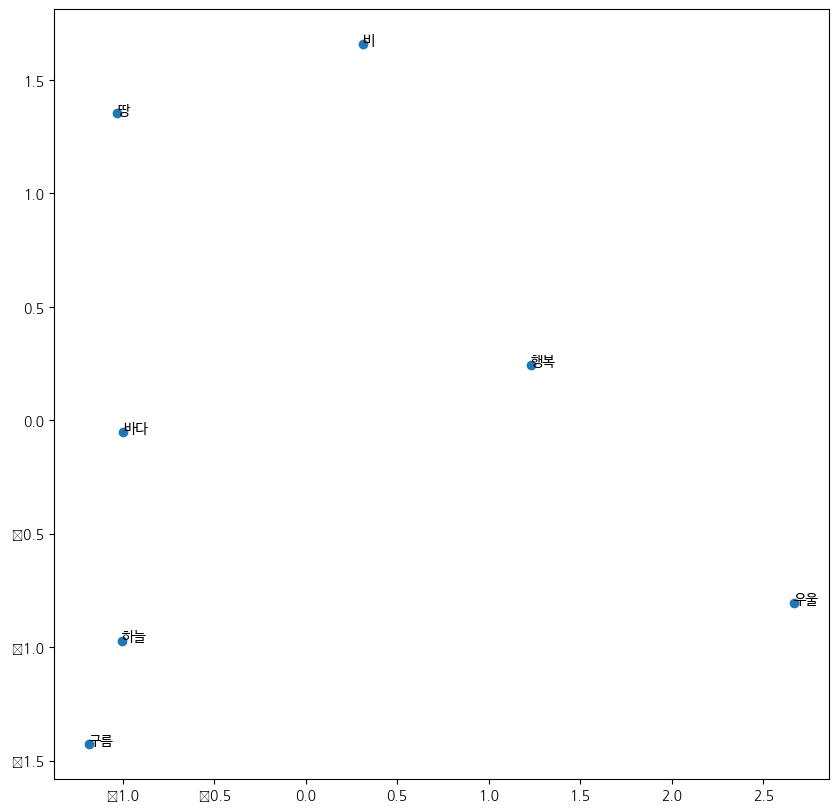

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)
xys = pca.fit_transform(visualize_list)
xs, ys = xys[:,0] , xys[:,1]
plt.figure(figsize=(10,10))
plt.scatter(xs,ys,marker='o')
plt.rc('font', family='NanumBarunGothic')
for i, word in enumerate(word_list):
  plt.annotate(word, xy=(xs[i],ys[i]))
plt.show()